<a href="https://colab.research.google.com/github/eb-adutwum/deeplearningprositone/blob/main/Elijah_Boateng_Deep_Learning_PROSIT_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files, drive
from collections import defaultdict

import torch
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset, Dataset, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Getting the Dataset

## Downloading and moving to the cloud

In [4]:
# files.upload() # kaggle api token

In [5]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !mkdir -p /content/drive/MyDrive/KaggleData/CINIC10

In [7]:
# !kaggle datasets download -d mengcius/cinic10 -p /content/drive/MyDrive/KaggleData/CINIC10


In [8]:
# !unzip /content/drive/MyDrive/KaggleData/CINIC10/cinic10.zip -d /content/drive/MyDrive/KaggleData/CINIC10

## Verifying data upload

In [109]:
dataset = '/content/drive/MyDrive/KaggleData/CINIC10'

In [10]:
def count_files_and_folders(path):
    total_files = 0
    total_folders = 0
    print(f"{path}/")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)

        indent = ' ' * 4 * (level)
        print(f'{indent}|-- {os.path.basename(root)}/')

        subindent = ' ' * 4 * (level + 1)
        print(f'{subindent}|-- Folders: {len(dirs)}')
        print(f'{subindent}|-- Files: {len(files)}')
        total_files += len(files)
        total_folders += len(dirs)
    print(f"\nTotal Folders: {total_folders}")
    print(f"Total Files: {total_files}")

In [11]:
count_files_and_folders(dataset)

/content/drive/MyDrive/KaggleData/CINIC10/
|-- CINIC10/
    |-- Folders: 3
    |-- Files: 4
    |-- test/
        |-- Folders: 10
        |-- Files: 0
        |-- airplane/
            |-- Folders: 0
            |-- Files: 9000
        |-- automobile/
            |-- Folders: 0
            |-- Files: 9000
        |-- bird/
            |-- Folders: 0
            |-- Files: 9000
        |-- cat/
            |-- Folders: 0
            |-- Files: 9000
        |-- deer/
            |-- Folders: 0
            |-- Files: 9000
        |-- dog/
            |-- Folders: 0
            |-- Files: 9000
        |-- frog/
            |-- Folders: 0
            |-- Files: 9000
        |-- horse/
            |-- Folders: 0
            |-- Files: 9000
        |-- ship/
            |-- Folders: 0
            |-- Files: 9000
        |-- truck/
            |-- Folders: 0
            |-- Files: 9000
    |-- train/
        |-- Folders: 10
        |-- Files: 0
        |-- airplane/
            |-- Folders: 0


# Data Preprocessing

## Transforms for normaization


In [110]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),          # Ensure all images are 32x32
    transforms.ToTensor(),                # Convert to tensor [0,1]
    transforms.Normalize(
        mean=[0.4789, 0.4723, 0.4305],    # Training set stats
        std=[0.2421, 0.2383, 0.2587]
    ),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten (3,32,32) -> (3072,)
])

## Loading the data

In [111]:
train_data = ImageFolder("/content/drive/MyDrive/KaggleData/CINIC10/train",
                         transform=transform)
val_data   = ImageFolder("/content/drive/MyDrive/KaggleData/CINIC10/valid",
                         transform=transform)
test_data  = ImageFolder("/content/drive/MyDrive/KaggleData/CINIC10/test",
                         transform=transform)

### Sampling from each class

In [112]:
def balanced_subset(dataset, fraction=0.10):
    labels = np.array(dataset.targets)   # class labels from ImageFolder
    indices_by_class = defaultdict(list)

    # group indices by class
    for idx, label in enumerate(labels):
        indices_by_class[label].append(idx)

    # sample same fraction per class
    sampled_indices = []
    for cls, idxs in indices_by_class.items():
        n_samples = int(len(idxs) * fraction)
        sampled = np.random.choice(idxs, n_samples, replace=False)
        sampled_indices.extend(sampled)

    return Subset(dataset, sampled_indices)


In [113]:
# getting the splits
train_small = balanced_subset(train_data, 0.15)
val_small   = balanced_subset(val_data, 0.15)
test_small  = balanced_subset(test_data, 0.15)

In [114]:
print("Full dataset sizes:")
print("Train:", len(train_data))
print("Valid:", len(val_data))
print("Test:", len(test_data))

print("\nSampled dataset sizes")
print("Train small:", len(train_small))
print("Valid small:", len(val_small))
print("Test small:", len(test_small))


Full dataset sizes:
Train: 90000
Valid: 90000
Test: 90000

Sampled dataset sizes
Train small: 13500
Valid small: 13500
Test small: 13500


### Setting dataloaders for each set

In [29]:
train_loader = DataLoader(train_small, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_small, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_small, batch_size=64, shuffle=False, num_workers=2)

### View sample images

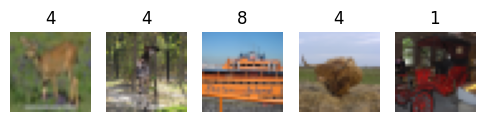

In [21]:
def imshow(img, mean=[0.4789, 0.4723, 0.4305], std=[0.2421, 0.2383, 0.2587]):
    # Ensure the image is in the correct shape (C, H, W) before transposing
    if img.ndim == 1: # If flattened, reshape
        img = img.view(3, 32, 32)
    img = img.numpy().transpose((1, 2, 0))   # CxHxW -> HxWxC
    img = std * img + mean                   # Unnormalize
    img = np.clip(img, 0, 1)                 # Clamp between [0,1]
    plt.imshow(img)
    plt.axis("off")

In [ ]:
# Take a batch from train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i])  # Pass the tensor directly
    plt.title(labels[i].item())
plt.show()

# Deep feed forward network

## Training

In [23]:
def train(model, num_epochs=10):
    train_losses = []

    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for i, (images, labels) in enumerate(train_loader, 1):

          # clear gradients
          optimizer.zero_grad()

          # get outputs
          outputs = model.forward_net(images)

          # calculate loss and do backprop
          loss = criterion(outputs, labels)
          loss.backward()

          # update weights
          optimizer.step()

          running_loss += loss.item()

          if i % 10 == 0:
            avg_loss = running_loss / 10
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            train_losses.append(avg_loss)
            running_loss = 0.0

      # Validation
      model.eval()
      correct, total = 0, 0

      with torch.no_grad():
        for images, labels in val_loader:
          outputs = model.forward_net(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Acc: {100*correct/total:.2f}%")
      print(train_losses)

## Bare Bones Model

In [30]:
# bare bones
class FeedforwardNet(nn.Module):
    def __init__(self):
        super(FeedforwardNet, self).__init__()
        self.fc1 = nn.Linear(3072, 1024)   # first hidden layer
        self.fc2 = nn.Linear(1024, 512)    # second hidden layer
        self.fc3 = nn.Linear(512, 256)     # third hidden layer
        self.fc4 = nn.Linear(256, 10)      # output layer

    def forward_net(self, x):
        x = x.view(x.size(0), -1) # Flatten the input here
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)   # logits
        return x

In [31]:
barebones_model = FeedforwardNet()

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
optimizer = torch.optim.SGD(barebones_model.parameters(), lr=0.01)

In [34]:
train(barebones_model, num_epochs=10)

Epoch [1/10], Batch [10/211], Loss: 2.3039
Epoch [1/10], Batch [20/211], Loss: 2.3006
Epoch [1/10], Batch [30/211], Loss: 2.2977
Epoch [1/10], Batch [40/211], Loss: 2.2909
Epoch [1/10], Batch [50/211], Loss: 2.2893
Epoch [1/10], Batch [60/211], Loss: 2.2821
Epoch [1/10], Batch [70/211], Loss: 2.2776
Epoch [1/10], Batch [80/211], Loss: 2.2735
Epoch [1/10], Batch [90/211], Loss: 2.2721
Epoch [1/10], Batch [100/211], Loss: 2.2579
Epoch [1/10], Batch [110/211], Loss: 2.2600
Epoch [1/10], Batch [120/211], Loss: 2.2513
Epoch [1/10], Batch [130/211], Loss: 2.2465
Epoch [1/10], Batch [140/211], Loss: 2.2451
Epoch [1/10], Batch [150/211], Loss: 2.2493
Epoch [1/10], Batch [160/211], Loss: 2.2385
Epoch [1/10], Batch [170/211], Loss: 2.2313
Epoch [1/10], Batch [180/211], Loss: 2.2326
Epoch [1/10], Batch [190/211], Loss: 2.2131
Epoch [1/10], Batch [200/211], Loss: 2.2183
Epoch [1/10], Batch [210/211], Loss: 2.2120
Epoch 1, Loss: 2.2035, Val Acc: 21.00%
[2.303881025314331, 2.3006375074386596, 2.2977

## Test

In [38]:
def test(model):
  model.eval()
  correct, total = 0, 0
  all_labels = [] # List to store true labels
  all_predictions = [] # List to store predicted labels

  with torch.no_grad():
      for images, labels in test_loader:
          outputs = model.forward_net(images)
          _, predicted = torch.max(outputs, 1)

          all_labels.extend(labels.tolist()) # Append true labels
          all_predictions.extend(predicted.tolist()) # Append predicted labels

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {100*correct/total:.2f}%")
  return all_labels, all_predictions # Return the lists

In [39]:
y, y_hat = test(barebones_model)

Test Accuracy: 35.74%


In [ ]:
# Plot after each epoch
def plot_losses(train_losses):
  plt.figure(figsize=(8,4))
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Iteration (every 10 batches)')
  plt.ylabel('Loss')
  plt.title('Training Loss Progress')
  plt.legend()
  plt.show()

## Conf Mtx

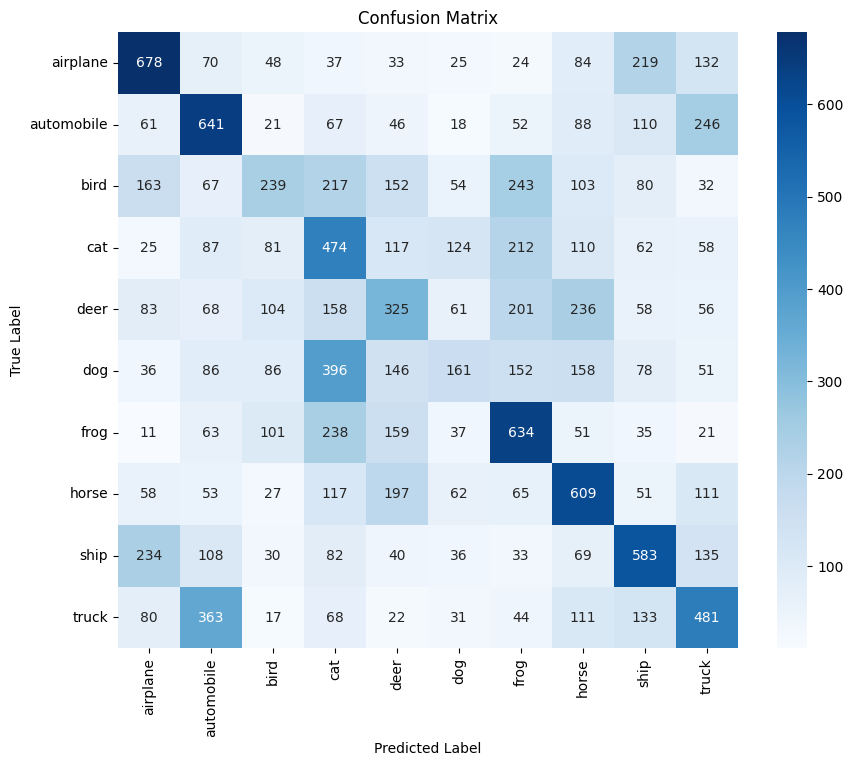

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'y' contains the true labels and 'y_hat' contains the predicted labels
# These should be obtained by calling the modified test function:
# y, y_hat = test(model)

# Calculate the confusion matrix
cm = confusion_matrix(y, y_hat)

# Get the class names from the dataset (assuming train_data is available and has class_to_idx)
# You might need to adjust this based on how your class names are stored
class_names = train_data.classes
# Or if you have a dictionary mapping indices to class names:
# class_names = {v: k for k, v in train_data.class_to_idx.items()}
# class_names = [class_names[i] for i in range(len(class_names))]


# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Attempts to improve performance

### Dropout + BatchNorm

In [48]:
class FeedForwardImprov(nn.Module):
  def __init__(self):
    super(FeedForwardImprov, self).__init__()
    self.fc1 = nn.Linear(3072, 1024)
    self.bn1 = nn.BatchNorm1d(1024)

    self.fc2 = nn.Linear(1024, 512)
    self.bn2 = nn.BatchNorm1d(512)

    self.fc3 = nn.Linear(512, 256)
    self.bn3 = nn.BatchNorm1d(256)

    self.fc4 = nn.Linear(256, 10)

    # Dropouts (only on last 2 layers)
    self.dropout2 = nn.Dropout(0.3)
    self.dropout3 = nn.Dropout(0.3)

  def forward_net(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = self.dropout2(x)
    x = F.relu(self.bn3(self.fc3(x)))
    x = self.dropout3(x)
    x = self.fc4(x)  # logits
    return x

In [49]:
imprv_model = FeedForwardImprov()

In [50]:
optimizer = torch.optim.SGD(imprv_model.parameters(), lr=0.01)

In [51]:
train(imprv_model, num_epochs=10)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [1/10], Batch [10/211], Loss: 2.3428
Epoch [1/10], Batch [20/211], Loss: 2.2332
Epoch [1/10], Batch [30/211], Loss: 2.1680
Epoch [1/10], Batch [40/211], Loss: 2.1074
Epoch [1/10], Batch [50/211], Loss: 2.1368
Epoch [1/10], Batch [60/211], Loss: 2.0793
Epoch [1/10], Batch [70/211], Loss: 2.0142
Epoch [1/10], Batch [80/211], Loss: 2.0486
Epoch [1/10], Batch [90/211], Loss: 1.9966
Epoch [1/10], Batch [100/211], Loss: 2.0280
Epoch [1/10], Batch [110/211], Loss: 1.9753
Epoch [1/10], Batch [120/211], Loss: 2.0107
Epoch [1/10], Batch [130/211], Loss: 1.9747
Epoch [1/10], Batch [140/211], Loss: 1.9525
Epoch [1/10], Batch [150/211], Loss: 1.9256
Epoch [1/10], Batch [160/211], Loss: 1.9524
Epoch [1/10], Batch [170/211], Loss: 1.9460
Epoch [1/10], Batch [180/211], Loss: 1.9571
Epoch [1/10], Batch [190/211], Loss: 1.9166
Epoch [1/10], Batch [200/211], Loss: 1.9349
Epoch [1/10], Batch [210/211], Loss: 1.9444


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 1, Loss: 1.7719, Val Acc: 33.13%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197]
Epoch [2/10], Batch [10/211], Loss: 1.7817
Epoch [2/10], Batch [20/211], Loss: 1.8621


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [2/10], Batch [30/211], Loss: 1.8237


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [2/10], Batch [40/211], Loss: 1.8102
Epoch [2/10], Batch [50/211], Loss: 1.8545
Epoch [2/10], Batch [60/211], Loss: 1.8286
Epoch [2/10], Batch [70/211], Loss: 1.8336
Epoch [2/10], Batch [80/211], Loss: 1.8182
Epoch [2/10], Batch [90/211], Loss: 1.8150
Epoch [2/10], Batch [100/211], Loss: 1.8738
Epoch [2/10], Batch [110/211], Loss: 1.7800
Epoch [2/10], Batch [120/211], Loss: 1.8221
Epoch [2/10], Batch [130/211], Loss: 1.8327
Epoch [2/10], Batch [140/211], Loss: 1.8268
Epoch [2/10], Batch [150/211], Loss: 1.8251
Epoch [2/10], Batch [160/211], Loss: 1.8472
Epoch [2/10], Batch [170/211], Loss: 1.8224
Epoch [2/10], Batch [180/211], Loss: 1.7402
Epoch [2/10], Batch [190/211], Loss: 1.8562
Epoch [2/10], Batch [200/211], Loss: 1.8195
Epoch [2/10], Batch [210/211], Loss: 1.8121


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2, Loss: 1.8676, Val Acc: 34.76%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():
     ^  ^^  ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch [3/10], Batch [10/211], Loss: 1.7170
Epoch [3/10], Batch [20/211], Loss: 1.7057
Epoch [3/10], Batch [30/211], Loss: 1.6881
Epoch [3/10], Batch [40/211], Loss: 1.7523
Epoch [3/10], Batch [50/211], Loss: 1.7326
Epoch [3/10], Batch [60/211], Loss: 1.7439
Epoch [3/10], Batch [70/211], Loss: 1.6634
Epoch [3/10], Batch [80/211], Loss: 1.6887
Epoch [3/10], Batch [90/211], Loss: 1.7538
Epoch [3/10], Batch [100/211], Loss: 1.7286
Epoch [3/10], Batch [110/211], Loss: 1.7795
Epoch [3/10], Batch [120/211], Loss: 1.6987
Epoch [3/10], Batch [130/211], Loss: 1.6723
Epoch [3/10], Batch [140/211], Loss: 1.6984
Epoch [3/10], Batch [150/211], Loss: 1.7143
Epoch [3/10], Batch [160/211], Loss: 1.7703
Epoch [3/10], Batch [170/211], Loss: 1.7345
Epoch [3/10], Batch [180/211], Loss: 1.6896
Epoch [3/10], Batch [190/211], Loss: 1.7364
Epoch [3/10], Batch [200/211], Loss: 1.7485
Epoch [3/10], Batch [210/211], Loss: 1.7407


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20> 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
 ^    self._shutdown_workers()^^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():^
 ^^  ^^ ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^^^ ^    ^ ^^   ^^^^^^
^^^^^  Fi

Epoch 3, Loss: 1.6772, Val Acc: 36.10%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError^: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [4/10], Batch [10/211], Loss: 1.6598
Epoch [4/10], Batch [20/211], Loss: 1.6244
Epoch [4/10], Batch [30/211], Loss: 1.6504
Epoch [4/10], Batch [40/211], Loss: 1.5952
Epoch [4/10], Batch [50/211], Loss: 1.6620
Epoch [4/10], Batch [60/211], Loss: 1.6593
Epoch [4/10], Batch [70/211], Loss: 1.6403
Epoch [4/10], Batch [80/211], Loss: 1.6255
Epoch [4/10], Batch [90/211], Loss: 1.6779
Epoch [4/10], Batch [100/211], Loss: 1.6222
Epoch [4/10], Batch [110/211], Loss: 1.6601
Epoch [4/10], Batch [120/211], Loss: 1.6555
Epoch [4/10], Batch [130/211], Loss: 1.6169
Epoch [4/10], Batch [140/211], Loss: 1.6643
Epoch [4/10], Batch [150/211], Loss: 1.7111
Epoch [4/10], Batch [160/211], Loss: 1.7005
Epoch [4/10], Batch [170/211], Loss: 1.6497
Epoch [4/10], Batch [180/211], Loss: 1.6494
Epoch [4/10], Batch [190/211], Loss: 1.5951
Epoch [4/10], Batch [200/211], Loss: 1.6476
Epoch [4/10], Batch [210/211], Loss: 1.6309


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4, Loss: 1.5842, Val Acc: 36.70%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
      ^ ^^  ^ ^^^^^^^^^^^^^^^^^^^
^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

Epoch [5/10], Batch [10/211], Loss: 1.5457
Epoch [5/10], Batch [20/211], Loss: 1.5358
Epoch [5/10], Batch [30/211], Loss: 1.5743
Epoch [5/10], Batch [40/211], Loss: 1.5218
Epoch [5/10], Batch [50/211], Loss: 1.5758
Epoch [5/10], Batch [60/211], Loss: 1.5583
Epoch [5/10], Batch [70/211], Loss: 1.5597
Epoch [5/10], Batch [80/211], Loss: 1.6087
Epoch [5/10], Batch [90/211], Loss: 1.5460
Epoch [5/10], Batch [100/211], Loss: 1.5430
Epoch [5/10], Batch [110/211], Loss: 1.6159
Epoch [5/10], Batch [120/211], Loss: 1.5654
Epoch [5/10], Batch [130/211], Loss: 1.6255
Epoch [5/10], Batch [140/211], Loss: 1.5810
Epoch [5/10], Batch [150/211], Loss: 1.6205
Epoch [5/10], Batch [160/211], Loss: 1.4798
Epoch [5/10], Batch [170/211], Loss: 1.5817
Epoch [5/10], Batch [180/211], Loss: 1.6220
Epoch [5/10], Batch [190/211], Loss: 1.5878
Epoch [5/10], Batch [200/211], Loss: 1.5647
Epoch [5/10], Batch [210/211], Loss: 1.6313


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5, Loss: 1.5783, Val Acc: 37.52%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [6/10], Batch [10/211], Loss: 1.4830


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [6/10], Batch [20/211], Loss: 1.4717
Epoch [6/10], Batch [30/211], Loss: 1.5156
Epoch [6/10], Batch [40/211], Loss: 1.4273
Epoch [6/10], Batch [50/211], Loss: 1.5195
Epoch [6/10], Batch [60/211], Loss: 1.4836
Epoch [6/10], Batch [70/211], Loss: 1.4809
Epoch [6/10], Batch [80/211], Loss: 1.5454
Epoch [6/10], Batch [90/211], Loss: 1.5052
Epoch [6/10], Batch [100/211], Loss: 1.4777
Epoch [6/10], Batch [110/211], Loss: 1.5143
Epoch [6/10], Batch [120/211], Loss: 1.5034
Epoch [6/10], Batch [130/211], Loss: 1.5573
Epoch [6/10], Batch [140/211], Loss: 1.5396
Epoch [6/10], Batch [150/211], Loss: 1.4949
Epoch [6/10], Batch [160/211], Loss: 1.4789
Epoch [6/10], Batch [170/211], Loss: 1.5522
Epoch [6/10], Batch [180/211], Loss: 1.4989
Epoch [6/10], Batch [190/211], Loss: 1.5341
Epoch [6/10], Batch [200/211], Loss: 1.5108
Epoch [6/10], Batch [210/211], Loss: 1.5324


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    self._shutdown_workers()    if w.is_alive():
  
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
    ^  ^^  ^^ ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^ 
   File "/usr/lib/pyth

Epoch 6, Loss: 1.5618, Val Acc: 37.54%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [7/10], Batch [10/211], Loss: 1.3839
Epoch [7/10], Batch [20/211], Loss: 1.4334
Epoch [7/10], Batch [30/211], Loss: 1.4417
Epoch [7/10], Batch [40/211], Loss: 1.4487
Epoch [7/10], Batch [50/211], Loss: 1.4344
Epoch [7/10], Batch [60/211], Loss: 1.4363
Epoch [7/10], Batch [70/211], Loss: 1.4025
Epoch [7/10], Batch [80/211], Loss: 1.4517
Epoch [7/10], Batch [90/211], Loss: 1.3897
Epoch [7/10], Batch [100/211], Loss: 1.4491
Epoch [7/10], Batch [110/211], Loss: 1.4007
Epoch [7/10], Batch [120/211], Loss: 1.4225
Epoch [7/10], Batch [130/211], Loss: 1.4437
Epoch [7/10], Batch [140/211], Loss: 1.3743
Epoch [7/10], Batch [150/211], Loss: 1.4973
Epoch [7/10], Batch [160/211], Loss: 1.4504
Epoch [7/10], Batch [170/211], Loss: 1.4497
Epoch [7/10], Batch [180/211], Loss: 1.4466
Epoch [7/10], Batch [190/211], Loss: 1.5124
Epoch [7/10], Batch [200/211], Loss: 1.4954
Epoch [7/10], Batch [210/211], Loss: 1.4674


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 7, Loss: 1.4617, Val Acc: 37.67%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
  Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  ^    ^self._shutdown_workers()^^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():
^ ^^^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
            ^^^^^^^^^^^^^^^^^^^^^^^^^

Epoch [8/10], Batch [10/211], Loss: 1.3417
Epoch [8/10], Batch [20/211], Loss: 1.3577
Epoch [8/10], Batch [30/211], Loss: 1.3493
Epoch [8/10], Batch [40/211], Loss: 1.3815
Epoch [8/10], Batch [50/211], Loss: 1.3672
Epoch [8/10], Batch [60/211], Loss: 1.4364
Epoch [8/10], Batch [70/211], Loss: 1.4054
Epoch [8/10], Batch [80/211], Loss: 1.3045
Epoch [8/10], Batch [90/211], Loss: 1.2736
Epoch [8/10], Batch [100/211], Loss: 1.3552
Epoch [8/10], Batch [110/211], Loss: 1.3418
Epoch [8/10], Batch [120/211], Loss: 1.4121
Epoch [8/10], Batch [130/211], Loss: 1.4146
Epoch [8/10], Batch [140/211], Loss: 1.3606
Epoch [8/10], Batch [150/211], Loss: 1.3779
Epoch [8/10], Batch [160/211], Loss: 1.4357
Epoch [8/10], Batch [170/211], Loss: 1.3762
Epoch [8/10], Batch [180/211], Loss: 1.4045
Epoch [8/10], Batch [190/211], Loss: 1.3886
Epoch [8/10], Batch [200/211], Loss: 1.4000
Epoch [8/10], Batch [210/211], Loss: 1.3662


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():
^^^  ^  ^   ^^^^

Epoch 8, Loss: 1.4739, Val Acc: 37.93%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         ^  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [9/10], Batch [10/211], Loss: 1.3149
Epoch [9/10], Batch [20/211], Loss: 1.2561


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [9/10], Batch [30/211], Loss: 1.2613
Epoch [9/10], Batch [40/211], Loss: 1.2635
Epoch [9/10], Batch [50/211], Loss: 1.2472
Epoch [9/10], Batch [60/211], Loss: 1.3425
Epoch [9/10], Batch [70/211], Loss: 1.2676
Epoch [9/10], Batch [80/211], Loss: 1.3465
Epoch [9/10], Batch [90/211], Loss: 1.2526
Epoch [9/10], Batch [100/211], Loss: 1.3076
Epoch [9/10], Batch [110/211], Loss: 1.3259
Epoch [9/10], Batch [120/211], Loss: 1.3122
Epoch [9/10], Batch [130/211], Loss: 1.3515
Epoch [9/10], Batch [140/211], Loss: 1.2507
Epoch [9/10], Batch [150/211], Loss: 1.3706
Epoch [9/10], Batch [160/211], Loss: 1.3381
Epoch [9/10], Batch [170/211], Loss: 1.3344
Epoch [9/10], Batch [180/211], Loss: 1.3522
Epoch [9/10], Batch [190/211], Loss: 1.3576
Epoch [9/10], Batch [200/211], Loss: 1.3672
Epoch [9/10], Batch [210/211], Loss: 1.3781


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      if w.is_alive():
           ^ ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^   ^  ^  ^^ ^
  File "/usr/l

Epoch 9, Loss: 1.2798, Val Acc: 38.14%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>    
if w.is_alive():
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      ^^if w.is_alive():^
   ^^ ^ ^^ ^^ ^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^^ ^^  ^ ^ 
   File "/usr/lib/

Epoch [10/10], Batch [10/211], Loss: 1.2144
Epoch [10/10], Batch [20/211], Loss: 1.1754
Epoch [10/10], Batch [30/211], Loss: 1.2043
Epoch [10/10], Batch [40/211], Loss: 1.2231
Epoch [10/10], Batch [50/211], Loss: 1.2618
Epoch [10/10], Batch [60/211], Loss: 1.1585
Epoch [10/10], Batch [70/211], Loss: 1.1737
Epoch [10/10], Batch [80/211], Loss: 1.2464
Epoch [10/10], Batch [90/211], Loss: 1.2174
Epoch [10/10], Batch [100/211], Loss: 1.2165
Epoch [10/10], Batch [110/211], Loss: 1.2842
Epoch [10/10], Batch [120/211], Loss: 1.2802
Epoch [10/10], Batch [130/211], Loss: 1.2988
Epoch [10/10], Batch [140/211], Loss: 1.2717
Epoch [10/10], Batch [150/211], Loss: 1.2721
Epoch [10/10], Batch [160/211], Loss: 1.2593
Epoch [10/10], Batch [170/211], Loss: 1.2523
Epoch [10/10], Batch [180/211], Loss: 1.2340
Epoch [10/10], Batch [190/211], Loss: 1.2981
Epoch [10/10], Batch [200/211], Loss: 1.3254
Epoch [10/10], Batch [210/211], Loss: 1.2614


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798394db1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10, Loss: 1.6826, Val Acc: 37.54%
[2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.663385045528

In [61]:
imprv_model_training_loss = [2.3427685737609862, 2.2332273960113525, 2.1679977655410765, 2.1073614716529847, 2.1367919206619264, 2.079269766807556, 2.0141802191734315, 2.0485867857933044, 1.9966115951538086, 2.027991199493408, 1.9753178238868714, 2.010699784755707, 1.9746754884719848, 1.9524875283241272, 1.925552785396576, 1.952432918548584, 1.945958387851715, 1.9570708870887756, 1.9165975451469421, 1.934946393966675, 1.9443867087364197, 1.7817241072654724, 1.862127673625946, 1.8236953973770142, 1.8102235198020935, 1.8544561624526978, 1.8285970330238341, 1.8336436986923217, 1.8182104706764222, 1.8150159120559692, 1.8738266348838806, 1.7800121903419495, 1.822070050239563, 1.83274188041687, 1.826763117313385, 1.8251437664031982, 1.847186839580536, 1.8223860025405885, 1.7402078628540039, 1.856213343143463, 1.8195152759552002, 1.812065064907074, 1.7169915437698364, 1.7056764483451843, 1.6881245255470276, 1.7522826671600342, 1.7325968265533447, 1.7438870787620544, 1.6633850455284118, 1.6886678457260131, 1.7538267016410827, 1.728643035888672, 1.7795062065124512, 1.6986849546432494, 1.6723377227783203, 1.6983836889266968, 1.7142734050750732, 1.7702695965766906, 1.7344820618629455, 1.6896422505378723, 1.736359703540802, 1.7485469818115233, 1.7407087445259095, 1.659796917438507, 1.6243707537651062, 1.6504254460334777, 1.5951674461364747, 1.6620031476020813, 1.659321165084839, 1.6403156757354735, 1.6255040407180785, 1.6779348254203796, 1.6222221612930299, 1.660126769542694, 1.655488705635071, 1.6168835043907166, 1.664253556728363, 1.7110879302024842, 1.7004881381988526, 1.649702000617981, 1.649444055557251, 1.5950687289237977, 1.6475657105445862, 1.6309085011482238, 1.5457282543182373, 1.5357600212097169, 1.5742624282836915, 1.521789789199829, 1.575757658481598, 1.558326256275177, 1.5597050189971924, 1.6086605429649352, 1.5460211396217347, 1.542988896369934, 1.6159460067749023, 1.565370011329651, 1.6254981756210327, 1.5809609055519105, 1.620530891418457, 1.4797585606575012, 1.5816820025444032, 1.621950876712799, 1.5878224968910217, 1.5646510601043702, 1.6313327074050903, 1.4829907298088074, 1.4716938614845276, 1.5156193137168885, 1.4273401021957397, 1.519498884677887, 1.4836417078971862, 1.4808840036392212, 1.545357310771942, 1.5051954984664917, 1.4777067661285401, 1.5143160104751587, 1.5033835768699646, 1.5572930693626403, 1.539601981639862, 1.4949320435523987, 1.4788618683815002, 1.5522314667701722, 1.4989477157592774, 1.5340582013130188, 1.510805857181549, 1.5324299097061158, 1.3839016914367677, 1.4333824872970582, 1.441708469390869, 1.4486884713172912, 1.4344064474105835, 1.4363270282745362, 1.4025435328483582, 1.4517296195030212, 1.3896544814109801, 1.449080801010132, 1.4006628274917603, 1.422500693798065, 1.44370836019516, 1.374261450767517, 1.4973420023918151, 1.4504273176193236, 1.4496950030326843, 1.4465778470039368, 1.5124478936195374, 1.49540833234787, 1.4673500061035156, 1.341661262512207, 1.3576795935630799, 1.3492587327957153, 1.381542146205902, 1.3672240376472473, 1.436432409286499, 1.4053850293159484, 1.3045310020446776, 1.2736458420753478, 1.3552194833755493, 1.3417516469955444, 1.4120930910110474, 1.4146066069602967, 1.3605526566505433, 1.3778703808784485, 1.4356593132019042, 1.3762188315391541, 1.4044959902763368, 1.3885708570480346, 1.4000429391860962, 1.366156852245331, 1.3148531675338746, 1.2561458945274353, 1.2612661838531494, 1.2635357618331908, 1.2471507430076598, 1.3425373196601869, 1.2676336646080018, 1.3464953303337097, 1.2526329636573792, 1.3075707793235778, 1.3258909463882447, 1.3122243762016297, 1.3515177607536315, 1.2507421314716338, 1.3705716848373413, 1.3381054401397705, 1.3344224452972413, 1.3521852016448974, 1.3576146245002747, 1.367186224460602, 1.3780567646026611, 1.2143503904342652, 1.1754119515419006, 1.2042858004570007, 1.2230829834938048, 1.2618213534355163, 1.158522117137909, 1.1737454652786254, 1.2464258670806885, 1.2174054741859437, 1.2164732336997985, 1.2841853499412537, 1.2801655650138855, 1.2988172769546509, 1.271664023399353, 1.2720555305480956, 1.2592539072036744, 1.252261793613434, 1.233984363079071, 1.2980630159378053, 1.3254042744636536, 1.2613608479499816]


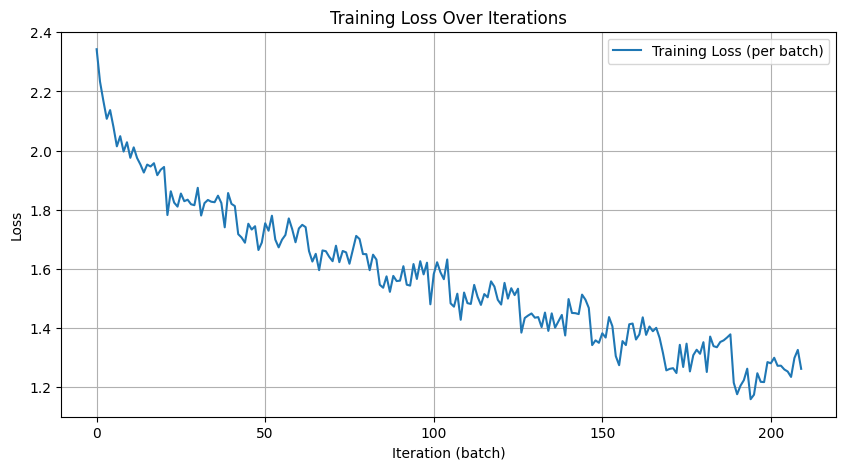

In [62]:
plt.figure(figsize=(10,5))
plt.plot(imprv_model_training_loss, label="Training Loss (per batch)")
plt.xlabel("Iteration (batch)")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.legend()
plt.grid(True)
plt.show()


In [63]:
improv_y, imrpov_y_hat = test(imprv_model)

Test Accuracy: 37.41%


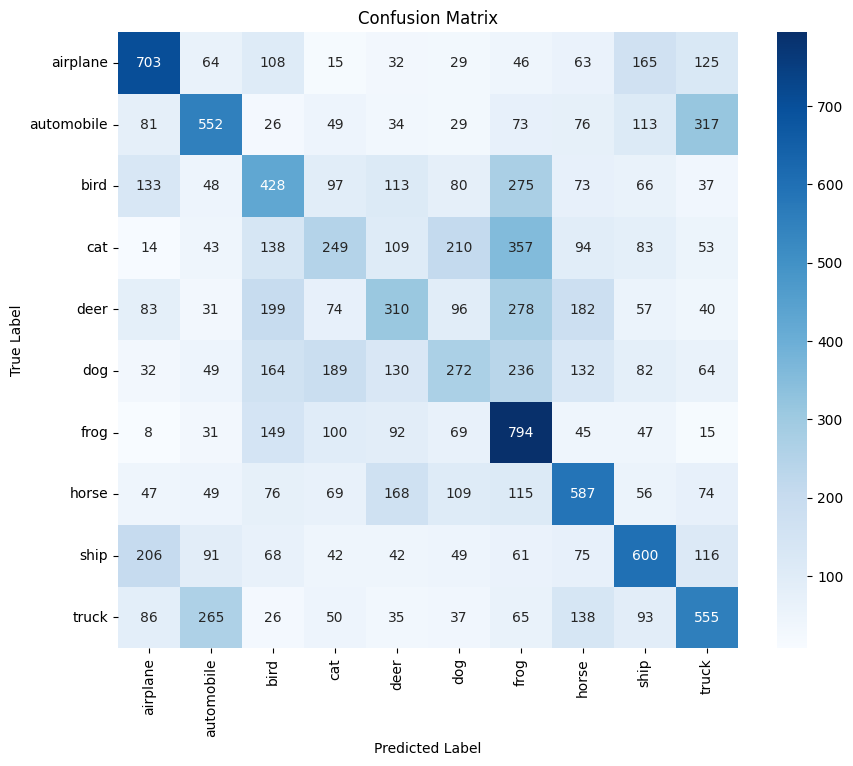

In [69]:
# confusion matrix
cm = confusion_matrix(improv_y, imrpov_y_hat)

class_names = train_data.classes

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Batch Norm + Dropout + Augmentation = Poor Outcome, had to stop

In [85]:
import random


class AugmentedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

        # Original transform (already resized, normalized, flattened)
        self.base_transform = transform

        # Grayscale augmentation
        self.grayscale_transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),  # convert to 3-channel grayscale
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4789, 0.4723, 0.4305],
                                 std=[0.2421, 0.2383, 0.2587]),
            transforms.Lambda(lambda x: x.view(-1))
        ])

        # Flip + Rotate augmentation 1
        self.aug_transform1 = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.RandomHorizontalFlip(p=0.9),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4789, 0.4723, 0.4305],
                                 std=[0.2421, 0.2383, 0.2587]),
            transforms.Lambda(lambda x: x.view(-1))
        ])

        # Flip + Rotate augmentation 2
        self.aug_transform2 = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.RandomHorizontalFlip(p=0.9),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=45),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4789, 0.4723, 0.4305],
                                 std=[0.2421, 0.2383, 0.2587]),
            transforms.Lambda(lambda x: x.view(-1))
        ])

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]

        # Load original image (before base transform)
        orig_path, _ = self.base_dataset.dataset.samples[self.base_dataset.indices[idx]]
        orig_img = self.base_dataset.dataset.loader(orig_path)  # PIL Image

        # Apply augmentations
        original = self.base_transform(orig_img)
        grayscale = self.grayscale_transform(orig_img)
        augmented1 = self.aug_transform1(orig_img)
        augmented2 = self.aug_transform2(orig_img)

        # Return all versions and label
        return {
            'original': original,
            'grayscale': grayscale,
            'augmented1': augmented1,
            'augmented2': augmented2,
            'label': label
        }


In [86]:
# Create augmented dataset
augmented_train_dataset = AugmentedDataset(train_small)

# Example: fetch one sample
sample = augmented_train_dataset[0]

# Access individual images
original_img = sample['original']
gray_img = sample['grayscale']
aug1 = sample['augmented1']
aug2 = sample['augmented2']
label = sample['label']

In [88]:
class FlattenedAugmentedDataset(Dataset):
    def __init__(self, base_dataset):
        self.aug_dataset = AugmentedDataset(base_dataset)

    def __len__(self):
        return 4 * len(self.aug_dataset)

    def __getitem__(self, idx):
        base_idx = idx // 4
        version = idx % 4
        sample = self.aug_dataset[base_idx]

        image = {
            0: sample['original'],
            1: sample['grayscale'],
            2: sample['augmented1'],
            3: sample['augmented2']
        }[version]

        return image, sample['label']

In [98]:
aug_train_dataset = FlattenedAugmentedDataset(train_small)
train_loader = DataLoader(aug_train_dataset, batch_size=64, shuffle=False)

In [99]:
len(aug_train_dataset)

54000

In [100]:
improv_model_aug = FeedForwardImprov()

In [101]:
train(improv_model_aug, num_epochs=10)

Epoch [1/10], Batch [10/844], Loss: 2.2302
Epoch [1/10], Batch [20/844], Loss: 2.2212
Epoch [1/10], Batch [30/844], Loss: 2.2269
Epoch [1/10], Batch [40/844], Loss: 2.2208
Epoch [1/10], Batch [50/844], Loss: 2.2341
Epoch [1/10], Batch [60/844], Loss: 2.2115
Epoch [1/10], Batch [70/844], Loss: 2.2143
Epoch [1/10], Batch [80/844], Loss: 2.2238
Epoch [1/10], Batch [90/844], Loss: 2.3270
Epoch [1/10], Batch [100/844], Loss: 2.4189
Epoch [1/10], Batch [110/844], Loss: 2.4270
Epoch [1/10], Batch [120/844], Loss: 2.4198
Epoch [1/10], Batch [130/844], Loss: 2.4304
Epoch [1/10], Batch [140/844], Loss: 2.4121
Epoch [1/10], Batch [150/844], Loss: 2.3990
Epoch [1/10], Batch [160/844], Loss: 2.4018
Epoch [1/10], Batch [170/844], Loss: 2.4064
Epoch [1/10], Batch [180/844], Loss: 2.2797
Epoch [1/10], Batch [190/844], Loss: 2.2820
Epoch [1/10], Batch [200/844], Loss: 2.2761
Epoch [1/10], Batch [210/844], Loss: 2.3029
Epoch [1/10], Batch [220/844], Loss: 2.2938
Epoch [1/10], Batch [230/844], Loss: 2.29

KeyboardInterrupt: 

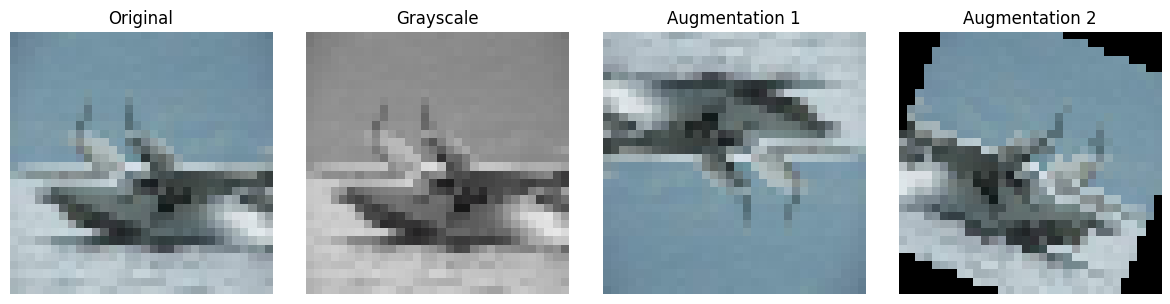

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize function
def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Pick a sample from the augmented dataset
sample = augmented_train_dataset[2]  # index can be any number < len(dataset)

# Unflatten and unnormalize each image
mean = [0.4789, 0.4723, 0.4305]
std = [0.2421, 0.2383, 0.2587]

def prepare_image(flat_tensor):
    img = flat_tensor.view(3, 32, 32)         # reshape
    img = unnormalize(img, mean, std)         # unnormalize
    img = img.permute(1, 2, 0).numpy()        # CHW -> HWC
    img = np.clip(img, 0, 1)                  # clip values for display
    return img

images = [
    prepare_image(sample['original']),
    prepare_image(sample['grayscale']),
    prepare_image(sample['augmented1']),
    prepare_image(sample['augmented2'])
]

titles = ['Original', 'Grayscale', 'Augmentation 1', 'Augmentation 2']

# Plot the images
plt.figure(figsize=(12, 3))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()


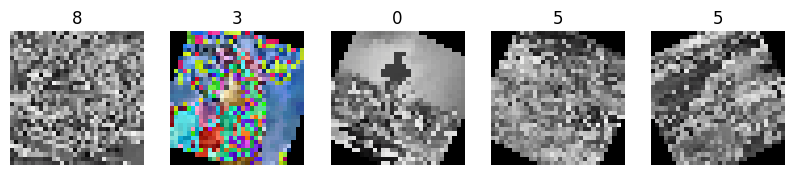

In [83]:
# Take a batch from the augmented train loader
dataiter_aug = iter(augmented_train_dataset)
images_aug, labels_aug = next(dataiter_aug)

# Show first 5 augmented images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # The images from train_aug_loader are already tensors, reshape back to (C, H, W) for imshow
    imshow(images_aug[i].view(3, 32, 32))
    plt.title(labels_aug[i].item())
plt.show()

In [65]:
class FeedForwardImprov(nn.Module):
  def __init__(self):
    super(FeedForwardImprov, self).__init__()
    self.fc1 = nn.Linear(3072, 1024)
    self.bn1 = nn.BatchNorm1d(1024)

    self.fc2 = nn.Linear(1024, 512)
    self.bn2 = nn.BatchNorm1d(512)

    self.fc3 = nn.Linear(512, 256)
    self.bn3 = nn.BatchNorm1d(256)

    self.fc4 = nn.Linear(256, 10)

    # Dropouts (only on last 2 layers)
    self.dropout2 = nn.Dropout(0.3)
    self.dropout3 = nn.Dropout(0.3)

  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = self.dropout2(x)
    x = F.relu(self.bn3(self.fc3(x)))
    x = self.dropout3(x)
    x = self.fc4(x)  # logits
    return x

In [66]:
model_imprv = FeedForwardImprov()

In [68]:
optimizer = torch.optim.SGD(model_imprv.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(model_imprv, num_epochs=10)

### Improve Model + PCA

In [115]:
def dataset_to_numpy(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    all_images = []
    all_labels = []

    for images, labels in loader:
        # Each image is already flattened to [3072]
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    X = np.concatenate(all_images, axis=0)  # shape: [N, 3072]
    y = np.concatenate(all_labels, axis=0)  # shape: [N]
    return X, y

In [119]:
from sklearn.decomposition import PCA

# datasets to NumPy
X_train, y_train = dataset_to_numpy(train_small)
X_val, y_val = dataset_to_numpy(val_small)
X_test, y_test = dataset_to_numpy(test_small)

# fit PCA
n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

KeyboardInterrupt: 

In [108]:
# Convert to tensors
train_dataset_pca = TensorDataset(torch.tensor(X_train_pca, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.long))
val_dataset_pca = TensorDataset(torch.tensor(X_val_pca, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.long))
test_dataset_pca = TensorDataset(torch.tensor(X_test_pca, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.long))

# Optional: Create loaders
train_loader = DataLoader(train_dataset_pca, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset_pca, batch_size=64)
test_loader = DataLoader(test_dataset_pca, batch_size=64)


In [ ]:
# Reshape first PCA component back to image
component_image = pca.components_[0].reshape(3, 32, 32)

# Convert to HWC and normalize to [0,1] for visualization
comp_img_np = component_image.transpose(1, 2, 0)
comp_img_np = (comp_img_np - comp_img_np.min()) / (comp_img_np.max() - comp_img_np.min())

plt.imshow(comp_img_np)
plt.title("PCA Component 1 as Image")
plt.axis('off')
plt.show()


In [ ]:
class FeedForwardPCA(nn.Module):
  def __init__(self):
    super(FeedForwardPCA, self).__init__()


# Save Model

In [84]:
torch.save(imprv_model.state_dict(), "feedforward_improv.pth")

# CNN

In [183]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),             # Ensure image size
    transforms.ToTensor(),                   # Convert to [C, H, W]
    transforms.Normalize(
        mean=[0.4789, 0.4723, 0.4305],        # Normalize RGB channels
        std=[0.2421, 0.2383, 0.2587]
    )
])


In [184]:
train_data = ImageFolder("/content/drive/MyDrive/KaggleData/CINIC10/train", transform=transform)
train_small = balanced_subset(train_data, 0.15)

train_loader = DataLoader(train_small, batch_size=64, shuffle=True)

In [185]:
class SimpleCNN(nn.Module):
  def __init__(self, output_dim=300):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # (B, 32, 32, 32)
    self.pool1 = nn.MaxPool2d(2, 2)                          # (B, 32, 16, 16)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (B, 64, 16, 16)
    self.pool2 = nn.MaxPool2d(2, 2)                           # (B, 64, 8, 8)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 8, 8)
    self.pool3 = nn.MaxPool2d(2, 2)                           # (B, 128, 4, 4)

    self.flatten = nn.Flatten()
    self.fc = nn.Linear(128 * 4 * 4, output_dim)  # Final feature vector

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x  # Feature vector


In [199]:
class FeedForwardImprov(nn.Module):
    def __init__(self, input_dim=3072):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.fc4 = nn.Linear(256, 10)

        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)

    def forward_net(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


In [201]:
# Load the saved model
checkpoint = torch.load('feedforward.pth')
feedforward_model = FeedForwardImprov(input_dim=300)

# Remove fc1 weights from checkpoint
del checkpoint['fc1.weight']
del checkpoint['fc1.bias']

feedforward_model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['fc1.weight', 'fc1.bias'], unexpected_keys=[])

In [202]:
class StackedCNN_FF(nn.Module):
    def __init__(self, cnn, ff_model):
        super(StackedCNN_FF, self).__init__()
        self.cnn = cnn
        self.ff = ff_model

    def forward(self, x):
        features = self.cnn(x)     # [B, 300]
        logits = self.ff.forward_net(features)  # [B, 10]
        return logits


In [203]:
cnn_model = SimpleCNN(output_dim=300)

In [204]:
stacked_model = StackedCNN_FF(cnn_model, feedforward_model)

In [205]:
for param in feedforward_model.parameters():
    param.requires_grad = False

In [206]:
optimizer = torch.optim.SGD(stacked_model.parameters(), lr=0.01)

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_losses = []
val_accuracies = []

num_epochs = 10

stacked_model.train()  # just to be sure

for epoch in range(num_epochs):
    stacked_model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = stacked_model(images)  # <-- don't use forward_net, just call model directly
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print every 10 batches
        if i % 10 == 0:
            avg_loss = running_loss / 10
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            train_losses.append(avg_loss)
            running_loss = 0.0

    # Validation after each epoch
    stacked_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = stacked_model(images)  # <-- again, just call model directly
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Final Batch Loss: {loss.item():.4f}, Val Acc: {val_acc:.2f}%")

print("Training complete!")


In [209]:
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 3, 32, 32)
    break


torch.Size([64, 3, 32, 32])
